In [5]:
# - Download Julia from https://julialang.org/downloads/
# - Install Julia
# - Run Julia
# In the julia repl run:
# ] (to enter Pkg mode)
# add Plots
# add EzXML
# add IJulia
# (backspace to go back)
# using IJulia
# notebook()
# y

using Statistics
using Plots
using EzXML

In [6]:
function Haversine(x, y)
    # snippet taken from Distances.jl
    λ₁, φ₁ = x
    λ₂, φ₂ = y
    
    Δλ = λ₂ - λ₁  # longitudes
    Δφ = φ₂ - φ₁  # latitudes

    # haversine formula
    a = sind(Δφ/2)^2 + cosd(φ₁)*cosd(φ₂)*sind(Δλ/2)^2

    # distance on the sphere
    radius = 6_371_000
    2 * (radius * asin( min(√a, one(a)) )) # take care of floating point errors
end

function KalmanJS(xs, R = 1, Q = 1, A = 1, B = 0, C = 1)
    # ported to julia from kalmanjs
    cov = missing;
    x = missing;

    function _filter(z, u = 0)
        u = 0;
        
        if ismissing(x)
            x = (1 / C) * z;
            cov = (1 / C) * Q * (1 / C);
        else
            # Compute prediction
            predX = (A * x) + (B * u);
            predCov = ((A * cov) * A) + R;
    
            # Kalman gain
            K = predCov * C * (1 / ((C * predCov * C) + Q));
    
            # Correction
            x = predX + K * (z - (C * predX));
            cov = predCov - (K * C * predCov);
        end

        x
    end

    map((x) -> _filter(x), xs)
end

function parse_track_segment(trkseg)
    prev_elevation = 0
    track = []

    for trkpt in elements(trkseg)
        lon = parse(Float64, trkpt["lon"])
        lat = parse(Float64, trkpt["lat"])
        elevation = prev_elevation

        for ele in elements(trkpt)
            if nodename(ele) == "ele"
                elevation = parse(Float64, nodecontent(ele))
                prev_elevation = parse(Float64, nodecontent(ele))
            end
        end

        push!(track, [lon, lat, elevation])
    end

    return track
end

parse_track_segment (generic function with 1 method)

In [7]:
struct SlopeData
    slope
    min
    max
    mean
    var
    std
end

struct TargetSlopeData
    max
    mean
end

function tract_to_vectors(track)
    distances = Vector{Float64}()
    distance = zeros(1)
    slopes = Vector{Float64}()
    elevations = map((p) -> p[3], track)
    
    Y = track
    X = Y[2:end]

    for (x, y) in zip(X, Y)
        d = Haversine(x, y)

        h = x[3] - y[3]
        slope = (h / d) * 100
        d_sum = last(distance) + d
        
        push!(distances, d)
        push!(slopes, slope)
        push!(distance, d_sum)
    end

    (slopes, elevations, distances, distance)
end

function vec_to_slope_data(slopes)
    slope_min = minimum(slopes)
    slope_max = maximum(slopes)
    slope_mean = mean(slopes)
    slope_var = var(slopes)
    slope_std = std(slopes)
    
    SlopeData(slopes, slope_min, slope_max, slope_mean, slope_var, slope_std)
end

function plot_slope_data(data, target, lims = [])
    slope = data.slope

    if lims == []
        ylims = (data.min-1, data.max+1)
    else
        ylims = lims
    end

    above_target_max = length(filter((s) -> s > target.max, slope))

    y1 = slope
    y2 = fill(target.mean, length(y1))
    y3 = fill(data.mean, length(y1))
    y4 = fill(target.max, length(y1))
    plot(
        [y1 y2 y3 y4],
        lw=[3 2 2 1],
        ls=[:dot :solid :solid :solid],
        ylims=ylims,
        ylabel="slope",
        xlabel="records",
        minorgrid=true,
        size = (1200, 400),
        margin=5Plots.mm,
        #legend=:outertop,
        label=["slope" "μ: $(round(data.mean, digits=2))" "μₜ: $(target.mean) ϵ: $(round(data.mean - target.mean, digits=2))" "maxₜ: $(target.max), ϵ: $(above_target_max)"]
    )
end

function file_to_vecs(path)
    doc = readxml(path)
    ns = namespace(doc.root)
    trkseg = findall("//x:trkseg", doc.root, ["x"=>ns])[1]
    
    track = parse_track_segment(trkseg)
    tract_to_vectors(track)
end

function file_to_plot(path, target, lims = [])
    vecs = file_to_vecs(path)
    data = vec_to_slope_data(vecs[1])
    plot_slope_data(data, target, lims)
end

# print(slope_data_to_string(data))

file_to_plot (generic function with 2 methods)

In [8]:
function plot_slopes(dataA, dataB, target, lims = [])
    A = dataA.slope
    B = dataB.slope

    if lims == []
        ylims = (dataA.min-1, dataA.max+1)
    else
        ylims = lims
    end

    above_target_maxA = length(filter((s) -> s > target.max, A))
    above_target_maxB = length(filter((s) -> s > target.max, B))

    y1 = A
    y2 = B
    y3 = fill(target.max, length(y1))
    
    plot(
        [y1 y2 y3],
        lw=[3 2 1],
        ls=[:dot :dot :solid],
        color=[1 2 4],
        # ylims=(dataA.min-1, dataA.max+1),
        ylims = ylims,
        ylabel="slope",
        xlabel="records",
        minorgrid=true,
        margin=5Plots.mm,
        size = (1200, 400),
        label=["A, ϵ: $(round(dataA.mean - target.mean, digits=2))" "B, ϵ: $(round(dataB.mean - target.mean, digits=2))" "maxₜ: $(target.max), ϵ₁: $(above_target_maxA) ϵ₂: $(above_target_maxB)"]
    )
end

function file_to_filter_plot(path, target, R = 1, Q = 1, lims = [])
    vecs = file_to_vecs(path)

    A = vec_to_slope_data(vecs[1])
    B = vec_to_slope_data(
        KalmanJS(vecs[1], R, Q)
    )
    
    plot_slopes(A, B, target, lims)
end

file_to_filter_plot (generic function with 4 methods)

In [9]:
# Alpe d'Huez (VeloViewer data):
# avg grade: 7.8%,
# max grade: 11.8%,
# start elevation: 769m,
# end elevation: 1892m,
# climb: 1127m
alpe_target = TargetSlopeData(11.8, 7.8)

# files
alpe_edge830_13 = "./data/Alpe-d-Huez-13km-Edge830.gpx"
alpe_edge830_13_kalman = "./data/Alpe-d-Huez-13km-Edge830-Kalman0.001-7.gpx"

alpe_strava_export = "./data/Alpe-d-Huez-Strava-Route.gpx"
alpe_garmin_export = "./data/"

"./data/"

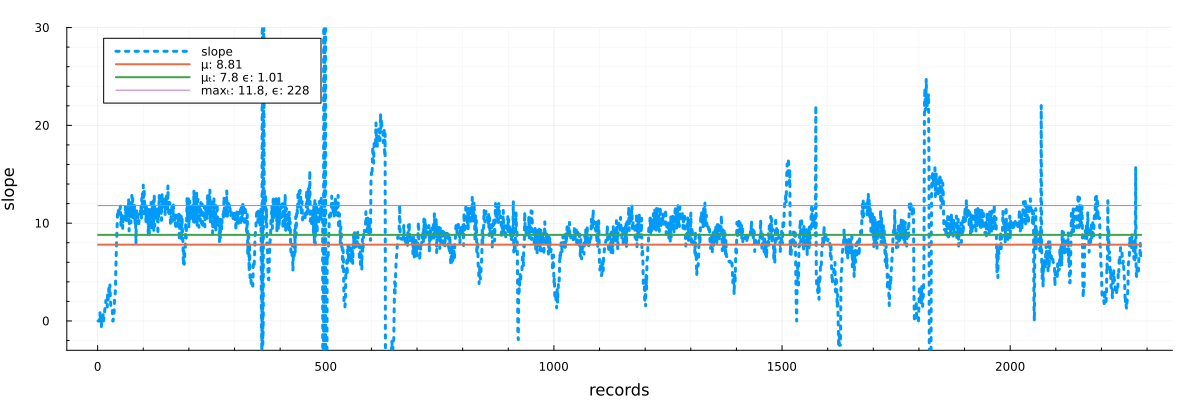

In [15]:
# Original file recorded with Garmin Edge 830 at TdF 2022
file_to_plot(alpe_edge830_13, alpe_target, [-3, 30])

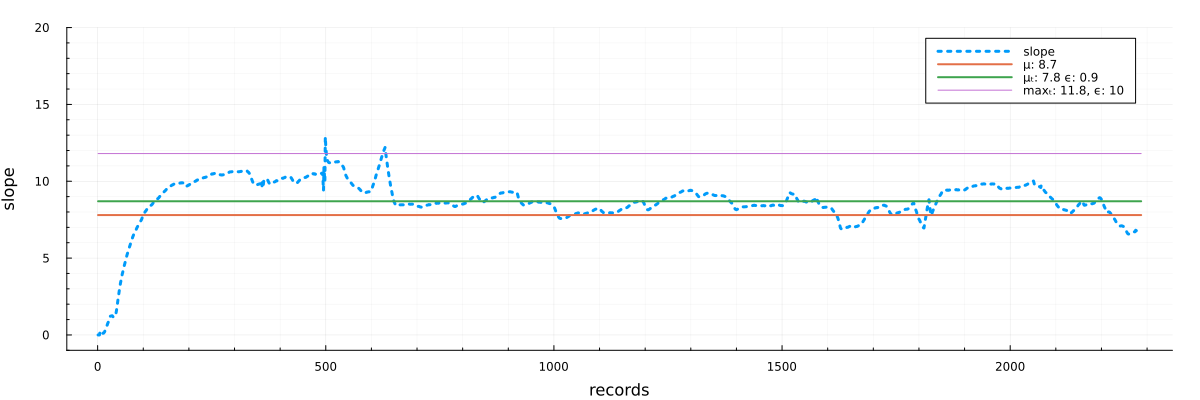

In [16]:
# second file produced by applying Kalman filter to original file with https://www.potter.ca/Biking/smoother-beta/
file_to_plot(alpe_edge830_13_kalman, alpe_target, [-1, 20])

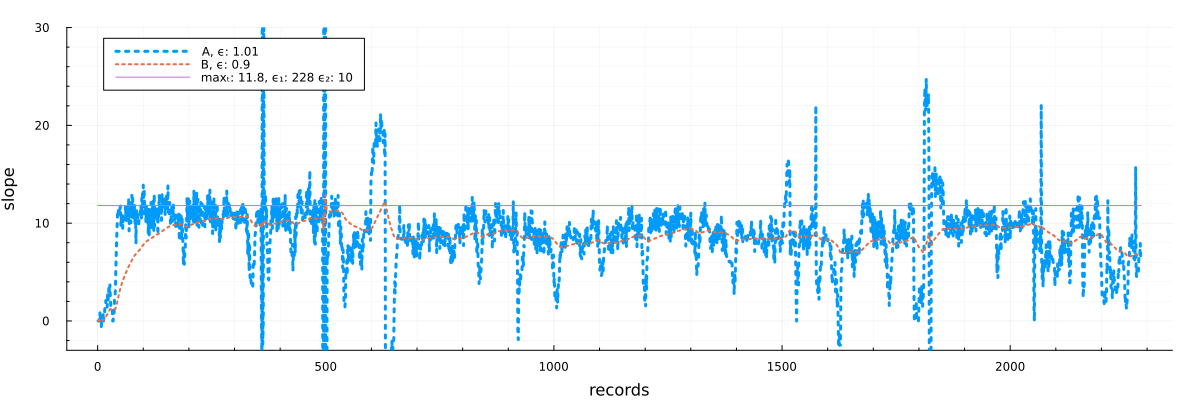

In [17]:
# Original file + Kalman filter applied locally
file_to_filter_plot(alpe_edge830_13, alpe_target, 0.001, 7, [-3, 30])

In [80]:
# Harrogate (VeloViewer data):
# avg grade: 0.0%,
# max grade: 8.3%,
# min elevation: 97m
# max elevation: 183m
# elevation gain: 240m
harrogate_target = TargetSlopeData(8.3, 0.0)

# files
harrogate_zwift = "./data/Harrogate-Zwift.gpx"
harrogate_strava_ride = "./data/Harrogate-Strava-Ride.gpx"
harrogate_bt_ride = "./data/Harrogate-BT-ride.gpx"

"./data/Harrogate-BT-ride.gpx"

In [82]:
function plot_elevation(path)
    vecs = file_to_vecs(path)
    elevation = vecs[2]
    distance = map((d) -> d / 1000, vecs[4])

    x = distance
    y1 = elevation
    # color = map((s) -> HSL((120 - (s * 8)), 0.45, 0.55), vecs[1])
    # push!(color, HSL(120, 0.45, 0.55))
    
    plot(
        x,
        [y1],
        #color=color,
        seriestype= :sticks,
        ylabel="elevation",
        xlabel="records",
        minorgrid=true,
        margin=5Plots.mm,
        size = (1200, 400),
        label=["Elevation"]
    )
end

plot_elevation (generic function with 1 method)

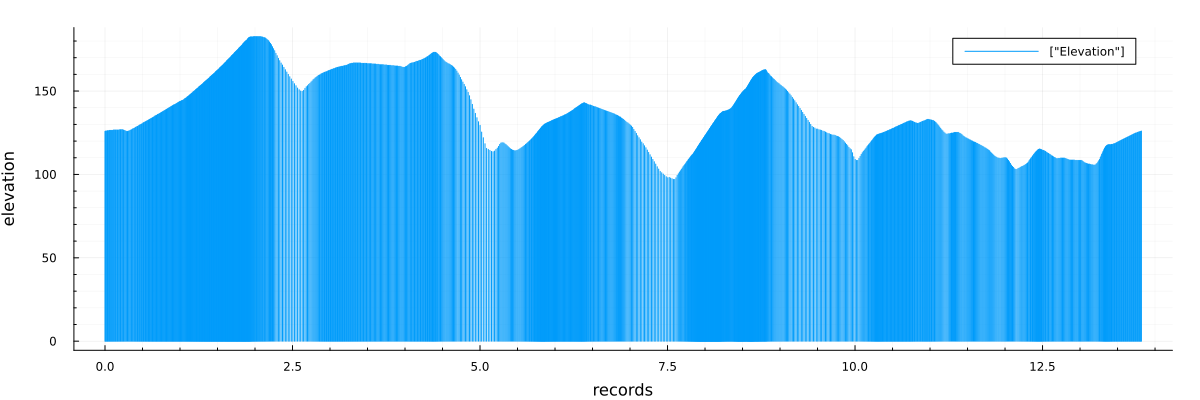

In [85]:
plot_elevation(harrogate_zwift)